## Initial Data Exploration

In [1]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('you got an issue...')


In [2]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/24 23:39:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/24 23:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/02/24 23:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/02/24 23:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/02/24 23:39:51 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


• Data types - completed, all colummns are numbers now

• Ranges -  Use stats: yes
visualizations - yes box-plot, histogram

• Emptiness - good

• Uniqueness - duplicates are dropped! no primary keys

• Set memberships - confirmed.

• Foreign key set memberships - good,only allowed keys

• Regular expressions - good,none

• Cross-field validation - good

Open up CSV file:

In [3]:
df = spark.read.csv("heart.csv",header=True)

Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-4)

cp : Chest Pain type chest pain type

Value 0: typical angina Value 1: atypical angina Value 2: non-anginal pain Value 3: asymptomatic

trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

Number of Patients

In [4]:
df.count()

303

Now we register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL

In [5]:
df.createOrReplaceTempView("heart")
spark.sql("SELECT * FROM heart").show()

+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
|age|sex| cp|trtbps|chol|fbs|restecg|thalachh|exng|oldpeak|slp|caa|thall|output|
+---+---+---+------+----+---+-------+--------+----+-------+---+---+-----+------+
| 63|  1|  3|   145| 233|  1|      0|     150|   0|    2.3|  0|  0|    1|     1|
| 37|  1|  2|   130| 250|  0|      1|     187|   0|    3.5|  0|  0|    2|     1|
| 41|  0|  1|   130| 204|  0|      0|     172|   0|    1.4|  2|  0|    2|     1|
| 56|  1|  1|   120| 236|  0|      1|     178|   0|    0.8|  2|  0|    2|     1|
| 57|  0|  0|   120| 354|  0|      1|     163|   1|    0.6|  2|  0|    2|     1|
| 57|  1|  0|   140| 192|  0|      1|     148|   0|    0.4|  1|  0|    1|     1|
| 56|  0|  1|   140| 294|  0|      0|     153|   0|    1.3|  1|  0|    2|     1|
| 44|  1|  1|   120| 263|  0|      1|     173|   0|      0|  2|  0|    3|     1|
| 52|  1|  2|   172| 199|  1|      1|     162|   0|    0.5|  2|  0|    3|     1|
| 57|  1|  2|   150| 168|  0

In [6]:
# see colummns and data types
df.dtypes

[('age', 'string'),
 ('sex', 'string'),
 ('cp', 'string'),
 ('trtbps', 'string'),
 ('chol', 'string'),
 ('fbs', 'string'),
 ('restecg', 'string'),
 ('thalachh', 'string'),
 ('exng', 'string'),
 ('oldpeak', 'string'),
 ('slp', 'string'),
 ('caa', 'string'),
 ('thall', 'string'),
 ('output', 'string')]

In [7]:
# change datatypes 
df2 = spark.sql(''' 
SELECT  
  INT(age), 
  INT(sex), 
  INT(cp), 
  INT(trtbps), 
  INT(chol), 
  INT(fbs),
  INT(restecg),
  INT(thalachh),
  INT(exng),
  FLOAT(oldpeak),
  INT(slp),
  INT(caa),
  INT(thall),
  INT(output)
FROM heart 
''') 

In [8]:
# get rid if null values
no_null = df2.dropna()
no_null.count()

303

In [9]:
# get rid of duplicates
df3 = no_null.dropDuplicates()

In [10]:
df3.count()

302

Correlation Matrix

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df3.columns, outputCol=vector_col)
df_vector = assembler.transform(df3).select(vector_col)

In [12]:
import pandas as pd

# get correlation matrix
matrix = Correlation.corr(df_vector, 'corr_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = df3.columns, index= df3.columns) 

/var/folders/9g/dbpjb98j0f309r0sq0xtxb8r0000gn/T/ipykernel_4360/1337763602.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
24/02/24 23:40:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<Axes: >

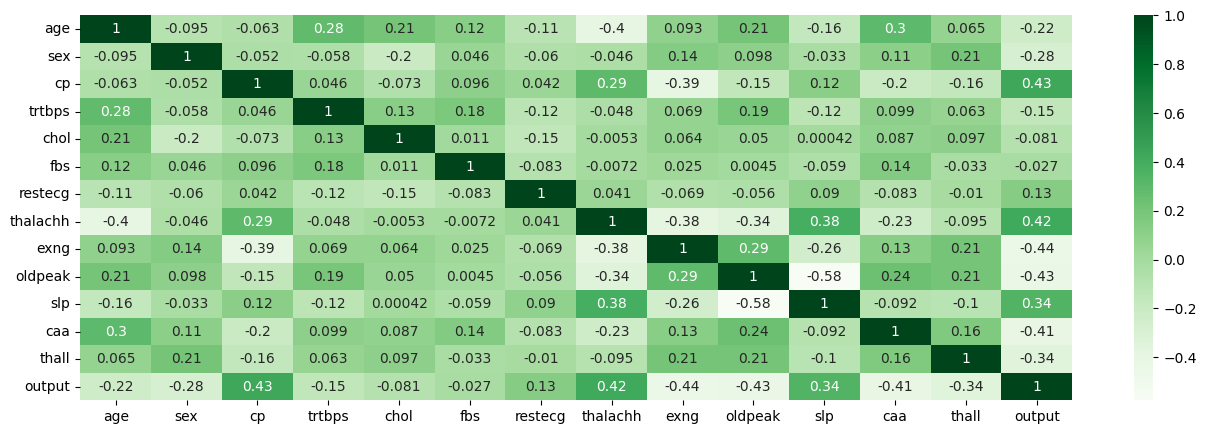

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

Check out ranges of columns that are not categorical

In [14]:
from pyspark.sql import functions as F

In [15]:
df3.agg(F.min(df3.age), F.max(df3.age),F.avg(df3.age), F.std(df3.age)).show()

+--------+--------+------------------+-----------------+
|min(age)|max(age)|          avg(age)|         std(age)|
+--------+--------+------------------+-----------------+
|      29|      77|54.420529801324506|9.047969746247453|
+--------+--------+------------------+-----------------+



In [16]:
df3.agg(F.min(df3.trtbps), F.max(df3.trtbps),F.avg(df3.trtbps), F.std(df3.trtbps)).show()

+-----------+-----------+------------------+------------------+
|min(trtbps)|max(trtbps)|       avg(trtbps)|       std(trtbps)|
+-----------+-----------+------------------+------------------+
|         94|        200|131.60264900662253|17.563394230037556|
+-----------+-----------+------------------+------------------+



In [17]:
df3.agg(F.min(df3.chol), F.max(df3.chol),F.avg(df3.chol), F.std(df3.chol)).show()

+---------+---------+---------+------------------+
|min(chol)|max(chol)|avg(chol)|         std(chol)|
+---------+---------+---------+------------------+
|      126|      564|    246.5|51.753488655740576|
+---------+---------+---------+------------------+



In [18]:
df3.agg(F.min(df3.thalachh), F.max(df3.thalachh),F.avg(df3.thalachh), F.std(df3.thalachh)).show()

+-------------+-------------+------------------+------------------+
|min(thalachh)|max(thalachh)|     avg(thalachh)|     std(thalachh)|
+-------------+-------------+------------------+------------------+
|           71|          202|149.56953642384107|22.903527251969845|
+-------------+-------------+------------------+------------------+



In [19]:
df3.agg(F.min(df3.oldpeak), F.max(df3.oldpeak), F.avg(df3.oldpeak), F.std(df3.oldpeak)).show()

+------------+------------+------------------+------------------+
|min(oldpeak)|max(oldpeak)|      avg(oldpeak)|      std(oldpeak)|
+------------+------------+------------------+------------------+
|         0.0|         6.2|1.0430463560122922|1.1614522772331766|
+------------+------------+------------------+------------------+



Set Memberships

In [20]:
cat_cols = ['sex','cp','fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']

#df.select("name").rdd.flatMap(lambda x: x).collect()
for col in cat_cols:
    print(f'{col} values - {df.select(col).distinct().collect()}')

sex values - [Row(sex='0'), Row(sex='1')]
cp values - [Row(cp='3'), Row(cp='0'), Row(cp='1'), Row(cp='2')]
fbs values - [Row(fbs='0'), Row(fbs='1')]
restecg values - [Row(restecg='0'), Row(restecg='1'), Row(restecg='2')]
exng values - [Row(exng='0'), Row(exng='1')]
slp values - [Row(slp='0'), Row(slp='1'), Row(slp='2')]
caa values - [Row(caa='3'), Row(caa='0'), Row(caa='1'), Row(caa='4'), Row(caa='2')]
thall values - [Row(thall='3'), Row(thall='0'), Row(thall='1'), Row(thall='2')]
output values - [Row(output='0'), Row(output='1')]


Data Visualization

In [21]:
age_array = df3.rdd.map(lambda row : row.age).sample(False,0.1).collect()

In [22]:
%matplotlib inline

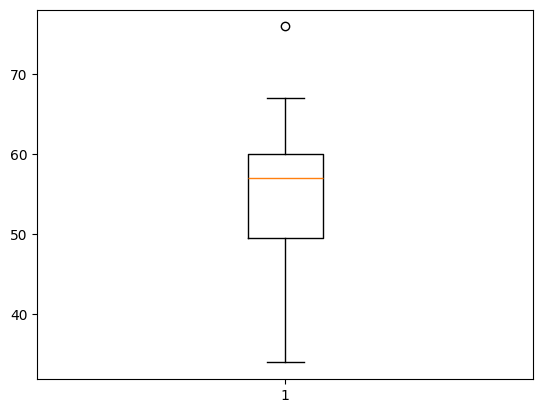

In [23]:
import matplotlib.pyplot as plt
plt.boxplot(age_array)
plt.show()

In [24]:
target_array = df3.rdd.map(lambda row : row.output).sample(False,0.1).collect()

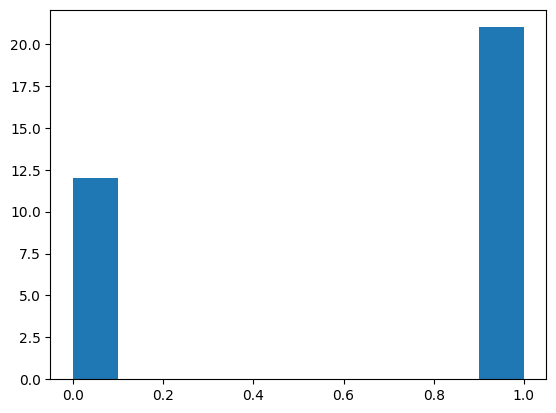

In [25]:
plt.hist(target_array)
plt.show()

Split up Train and Test data. Use seed so replication can reproduce similar results

In [26]:
splits = df3.randomSplit([0.80, 0.2],32)

In [27]:
df_train = splits[0]

In [28]:
df_test = splits[1]

## Feauture Engineering

In [29]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import Normalizer

In [30]:
indexer = StringIndexer(inputCol="output", outputCol="label")

In [31]:
encoder = OneHotEncoder(inputCol="label", outputCol="labelVec")

In [32]:
vectorAssembler = VectorAssembler(inputCols=['age','sex','cp','trtbps','chol','fbs','restecg',
 'thalachh','exng','oldpeak','slp', 'caa', 'thall'],outputCol="features")

In [33]:
normalizer = MinMaxScaler(inputCol="features", outputCol="features_norm")

## Model Definition

Linear Support Vector Classification

In [34]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=64, regParam=0.01,standardization=True)

In [35]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, normalizer,lsvc])

In [36]:
model = pipeline.fit(df_train)

24/02/24 23:40:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [37]:
prediction = model.transform(df_train)

In [38]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(prediction)

0.927817807514154

In [39]:
prediction = model.transform(df_test)

In [40]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [41]:
evaluator.evaluate(prediction)

0.875757575757576

In [42]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features_norm", numTrees=10)

In [43]:
pipeline2 = Pipeline(stages=[indexer, vectorAssembler, normalizer,rf])

In [44]:
model2 = pipeline2.fit(df_train)

In [45]:
prediction = model2.transform(df_train)

In [46]:
evaluator.evaluate(prediction)

0.9860396294390118

In [47]:
predictions = model2.transform(df_test)

In [48]:
evaluator.evaluate(prediction)

0.9860396294390118

Looks like Random Forest Classifier is the mest prediction model, let's see how we can change the parameters to increase the results. 

In [49]:
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features_norm", numTrees=12,maxDepth=8 )
pipeline2 = Pipeline(stages=[indexer, vectorAssembler, normalizer,rf2])
model2 = pipeline2.fit(df_train)
prediction2 = model2.transform(df_train)
evaluator.evaluate(prediction2)

0.9997426659804426

In [50]:
# Make predictions on test set
predictions2 = model2.transform(df_test)
evaluator.evaluate(prediction2)

0.9997426659804426

Deep Learning

In [51]:
train_test_split = df3.limit(256).randomSplit([0.7, 0.3],32)

In [52]:
train= train_test_split[0]
test = train_test_split[1]

In [53]:
X_train = train.drop('output')
X_test = test.drop('output')

In [54]:
Y_train = train.select("output")
Y_test = test.select("output")

In [55]:
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Dense, Dropout, Flatten, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.layers import LeakyReLU
from keras.optimizers import SGD

from keras import backend as K
import numpy as np

2024-02-24 23:40:26.921918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [56]:
batch_size = 32
num_classes = 10
epochs = 8

In [57]:
x_train = X_train.toPandas().astype('float64')
x_test = X_test.toPandas().astype('float64')

In [58]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(Y_train.toPandas(), num_classes)
y_test = keras.utils.to_categorical(Y_test.toPandas(), num_classes)

In [59]:
model = Sequential()
model.add(Dense(128, input_shape=(13,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(56))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

sgd = SGD(learning_rate=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

In [60]:
model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

print('\n')
print('Accuracy:',score[1])

Epoch 1/8
6/6 [==============================] - 1s 47ms/step - loss: 1393308.6250 - acc: 0.3956 - val_loss: 2.2021 - val_acc: 0.4324
Epoch 2/8
6/6 [==============================] - 0s 8ms/step - loss: 2.0948 - acc: 0.5055 - val_loss: 1.9701 - val_acc: 0.5541
Epoch 3/8
6/6 [==============================] - 0s 8ms/step - loss: 1.8653 - acc: 0.5330 - val_loss: 1.7648 - val_acc: 0.5541
Epoch 4/8
6/6 [==============================] - 0s 7ms/step - loss: 1.6766 - acc: 0.5330 - val_loss: 1.5835 - val_acc: 0.5541
Epoch 5/8
6/6 [==============================] - 0s 8ms/step - loss: 1.5058 - acc: 0.5330 - val_loss: 1.4227 - val_acc: 0.5541
Epoch 6/8
6/6 [==============================] - 0s 7ms/step - loss: 1.3568 - acc: 0.5330 - val_loss: 1.2815 - val_acc: 0.5541
Epoch 7/8
6/6 [==============================] - 0s 8ms/step - loss: 1.2323 - acc: 0.5330 - val_loss: 21366.3887 - val_acc: 0.4459
Epoch 8/8
6/6 [==============================] - 0s 8ms/step - loss: 6624.6304 - acc: 0.4890 - val_l

## Model Evalution

Evaluate for the best model: RandomForestClassifer


·      Confusion Matrix
·      Accuracy
·      Precision
·      Recall
·      F1-score
·      True positive rate
·      False positive rate

In [61]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [62]:
predictionAndLabels =  prediction2.rdd.map(lambda lp: (lp.prediction, lp.label))

metrics = BinaryClassificationMetrics(predictionAndLabels)

/Users/saraiaccheo/anaconda3/envs/cap_env/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [63]:
# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under PR = 0.9907586206896551
Area under ROC = 0.9827586206896552


In [64]:
from pyspark.mllib.evaluation import MulticlassMetrics
M_metrics = MulticlassMetrics(predictionAndLabels)

In [65]:
# precision
print("precision = %s" % M_metrics.precision(1.0))

# recall
print("recall = %s" % M_metrics.recall(1.0))

#f-1
print("f-1 = %s" %M_metrics.fMeasure(1.0))

precision = 1.0
recall = 0.9655172413793104
f-1 = 0.9824561403508771


In [66]:
# Confusion Matrix
M_metrics.confusionMatrix().toArray()

array([[134.,   0.],
       [  4., 112.]])

In [67]:
print("False Positive rate = %s" %M_metrics.falsePositiveRate(0.0))
print("True Positive rate = %s" %M_metrics.truePositiveRate(0.0))

False Positive rate = 0.034482758620689655
True Positive rate = 1.0


## Save Model

In [72]:
model2.write().overwrite().save("predict_heart_attack")